### Import model building libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential,Input
from tensorflow.keras.layers import Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Dense, Flatten
import tensorflow_addons as tfa

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

C:\Users\chris\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Image Preprocessing

In [2]:
import os
import shutil

dataset_path = r"Alzheimer_s Dataset"

combined_dataset_path = r"Dataset"

# Create the combined dataset folder if it doesn't exist
os.makedirs(combined_dataset_path, exist_ok=True)

# List of class folders to combine
class_folders = ["VeryMildDemented", "NonDemented", "MildDemented", "ModerateDemented"]

# Iterate through the "train" and "test" folders
for folder_name in ["train", "test"]:
    folder_path = os.path.join(dataset_path, folder_name)
    
    # Iterate through the class folders
    for class_folder in class_folders:
        class_path = os.path.join(folder_path, class_folder)
        
        # Iterate through the files in each class folder
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            # Copy the file to the combined dataset folder
            destination_path = os.path.join(combined_dataset_path, class_folder, file_name)
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            shutil.copy(file_path, destination_path)

In [4]:
#2. Configure image data generator
IMG_SIZE = 176
IMAGE_SIZE = [176,176]
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHTNESS = [0.8, 1.2]
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
train_datagen = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHTNESS, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=True)

In [5]:
#3. Apply image data generator functionality to train and test images
x_train = train_datagen.flow_from_directory(r"C:\Users\chris\Downloads\ADP Project\Dataset",target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [6]:
train_data, train_labels = x_train.next()
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [7]:
print(x_train.class_indices)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [8]:
#Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [9]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

## Model Building

In [10]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [11]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [12]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [13]:
model = construct_model()

In [14]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),tf.keras.metrics.AUC(name='auc'),tfa.metrics.F1Score(num_classes=4)]
model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)

In [15]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [16]:
#Fit the training data to the model and validate it using the validation data
model.fit(train_data, train_labels, validation_data=(val_data, val_labels),callbacks=my_callback,epochs=100)

Epoch 1/100
256/256 [==============================] - 494s 2s/step - loss: 1.6221 - acc: 0.3359 - auc: 0.5929 - f1_score: 0.3314 - val_loss: 1.7167 - val_acc: 0.2627 - val_auc: 0.5109 - val_f1_score: 0.1635
Epoch 2/100
256/256 [==============================] - 478s 2s/step - loss: 1.0226 - acc: 0.5470 - auc: 0.8125 - f1_score: 0.5353 - val_loss: 0.9580 - val_acc: 0.4839 - val_auc: 0.8260 - val_f1_score: 0.4089
Epoch 3/100
256/256 [==============================] - 462s 2s/step - loss: 0.8192 - acc: 0.6168 - auc: 0.8750 - f1_score: 0.6084 - val_loss: 1.3420 - val_acc: 0.5298 - val_auc: 0.7918 - val_f1_score: 0.4478
Epoch 4/100
256/256 [==============================] - 535s 2s/step - loss: 0.7540 - acc: 0.6484 - auc: 0.8937 - f1_score: 0.6390 - val_loss: 1.7164 - val_acc: 0.2905 - val_auc: 0.6131 - val_f1_score: 0.2062
Epoch 5/100
256/256 [==============================] - 467s 2s/step - loss: 0.7083 - acc: 0.6641 - auc: 0.9056 - f1_score: 0.6560 - val_loss: 0.8022 - val_acc: 0.6353 -

256/256 [==============================] - 421s 2s/step - loss: 0.0205 - acc: 0.9938 - auc: 0.9998 - f1_score: 0.9938 - val_loss: 0.2649 - val_acc: 0.9326 - val_auc: 0.9870 - val_f1_score: 0.9330
Epoch 80/100
256/256 [==============================] - 422s 2s/step - loss: 0.0258 - acc: 0.9905 - auc: 0.9997 - f1_score: 0.9905 - val_loss: 0.2379 - val_acc: 0.9429 - val_auc: 0.9867 - val_f1_score: 0.9431
Epoch 81/100
256/256 [==============================] - 423s 2s/step - loss: 0.0269 - acc: 0.9906 - auc: 0.9995 - f1_score: 0.9906 - val_loss: 0.2482 - val_acc: 0.9351 - val_auc: 0.9865 - val_f1_score: 0.9343
Epoch 82/100
256/256 [==============================] - 423s 2s/step - loss: 0.0149 - acc: 0.9950 - auc: 0.9998 - f1_score: 0.9950 - val_loss: 0.2552 - val_acc: 0.9399 - val_auc: 0.9857 - val_f1_score: 0.9397
Epoch 83/100
256/256 [==============================] - 423s 2s/step - loss: 0.0205 - acc: 0.9945 - auc: 0.9996 - f1_score: 0.9945 - val_loss: 0.4770 - val_acc: 0.8960 - val_auc

In [17]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

In [18]:
#save model
model.save('adp.h5')

C:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 18s 222ms/step - loss: 0.2650 - acc: 0.9391 - auc: 0.9832 - f1_score: 0.9387
Training Accuracy: 99.87%
Validation Accuracy: 93.07%
Testing Accuracy: 93.91%


In [20]:
#Predicting the test data
pred = model.predict(test_data)

80/80 [==============================] - 20s 228ms/step


In [21]:
pred_ls = np.argmax(pred, axis=1)
test_ls = np.argmax(test_labels, axis=1)
print(classification_report(test_ls, pred_ls))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       639
           1       1.00      1.00      1.00       635
           2       0.92      0.88      0.90       662
           3       0.93      0.88      0.90       624

    accuracy                           0.94      2560
   macro avg       0.94      0.94      0.94      2560
weighted avg       0.94      0.94      0.94      2560



In [22]:
confusion_matrix(test_ls, pred_ls)

array([[638,   0,   1,   0],
       [  0, 635,   0,   0],
       [ 39,   0, 585,  38],
       [ 25,   0,  53, 546]], dtype=int64)

### Testing the Model

In [24]:
model = load_model(r"adp.h5",compile=False)

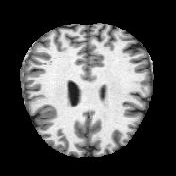

In [45]:
img = image.load_img(r"Dataset\NonDemented\32 (54).jpg",target_size=(176,176))
img

In [46]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)

In [50]:
pred = model.predict(x)
pred_class = np.argmax(pred,axis=1)
index = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
result = str(index[pred_class[0]])
result

1/1 [==============================] - 0s 194ms/step


'NonDemented'